<a href="https://colab.research.google.com/github/evril7490/test/blob/master/Classification_EDA_ModelValuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve,confusion_matrix
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import log_loss
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
font_size = 15
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

In [5]:
#### Explore Continuous variable

In [6]:
def explor_categorical_plots(train_df,
                             feat_cols,
                             target_col,
                             target_col_mapname=['Retained', 'Churned'],
                             colors = ['#00A5E0', '#DD403A'],
                             ):
  colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', 
                '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
  for feat_col in feat_cols:    
    fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
    sns.countplot(x=target_col, data=train_df, palette=colors_cat,ax=ax0)
    ax0.set_ylabel('Count')
    sns.countplot(x=feat_col,
                  hue=target_col,
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    if target_col_mapname:
      ax1.legend(labels=target_col_mapname)
    sns.barplot(x=feat_col,
                y=target_col,
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    plt.tight_layout();

In [7]:
# general hist plot
def plot_continuous_for_classification(data,
                    feat_col,
                    target_col,
                    target_col_mapname=['Retained', 'Churned'],
                    colors = ['#00A5E0', '#DD403A'],
                    ):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = data.copy()
    df_retained = df_func[df_func[target_col]==0]
    df_churned  = df_func[df_func[target_col]==1]
    df_func[target_col] = df_func[target_col].astype('category')
    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})
    for df, color, label in zip([df_retained, df_churned], colors, target_col_mapname):
        sns.histplot(data=df,
                     x=feat_col,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
        ax1.legend()

    sns.boxplot(x=feat_col, y=target_col, data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    if target_col_mapname:
      ax2.set_yticklabels(target_col_mapname)
    plt.tight_layout();

def explor_continuous_plots(train_df,
                            feat_cols,
                            target_col,
                            target_col_mapname=['Retained', 'Churned'],
                            plot_cols=2,
                          ):
  #### continous variable histogram plot
  rows = (len(feat_cols)+plot_cols-1)//plot_cols
  fig, ax = plt.subplots(rows, plot_cols, figsize=(6*plot_cols, 5*rows))
  for index, column in enumerate(feat_cols):
    plt.subplot(rows, plot_cols, index + 1)
    train_df[column].hist(bins=20,
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);
    plt.title(column)
  plt.show()
  for col in feat_cols:
    plot_continuous_for_classification(train_df,col,target_col=target_col,target_col_mapname=target_col_mapname)
  #### correlation heatmap plot
  fig, ax = plt.subplots(figsize=(12, 12))
  corr = train_df[feat_cols].corr()
  np.fill_diagonal(corr.values, np.nan)
  sns.heatmap(corr,
            #annot=True,
            #annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

  ax.tick_params(axis='x', rotation=45)
  ax.tick_params(axis='y', rotation=360);

In [8]:
### Fill Na for categorical columns and continuous columns
def fill_na(df,category_cols=[], cont_cols=[],
            fill_category_value='unknown',
            fill_na_dict=None):
  X = df.copy()
  if not fill_na_dict:# we have not provided the fill_missing_dict
    fill_na_dict = {}
    for col in category_cols:
      fill_na_dict[col] = fill_category_value

    for col in cont_cols:
      fill_na_dict[col] = X[col].mean()

  for feat_col,fill_value in fill_na_dict.items():
    X[feat_col].fillna(fill_value,inplace=True)

  return X,fill_na_dict


def target_encoder(df,feat_cols,target_col,post_fix='_TE',target_encode_dict=None):
  df = df.copy()
  if not target_encode_dict:
    target_encode_dict = {}
    for col in feat_cols:
      target_encode_dict[col] = dict(df.groupby(col)[target_col].mean())
  for col in feat_cols:
    df[f'{col}{post_fix}'] = df[col].map(target_encode_dict[col])
  
  return df,target_encode_dict

def one_hot_encoder(df,feat_cols,enc_dict=None):
  enc_df = []
  # if enc_dict is not provided, will run the feats and create the encode dict
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = OneHotEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = enc
  
  for feat_col in feat_cols:
    enc = enc_dict[feat_col]
    enc_df.append( pd.DataFrame(enc.transform(df[[feat_col]]).toarray(),columns= [ f'{feat_col}_{k}' for k in enc.categories_[0] ],index=df.index ) )
  
  enc_df = pd.concat(enc_df,axis=1)
  for col in enc_df:
    if col in df:
      print(f'Will overwrite {col} since it already exist in df')
      df = df.drop(columns=[col])
  df = pd.concat([ df,enc_df], axis=1)
  return df,enc_dict

def label_encoder(df,feat_cols,enc_dict=None,postfix='_LE'):
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = LabelEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

  for feat_col in feat_cols:
    df[f'{feat_col}{postfix}'] = df[feat_col].map(enc_dict[feat_col])
  return df,enc_dict


def preprocess_test(test_df,preprocess_dict):
  df = test_df.copy()
  if 'fill_na_dict' in preprocess_dict:
    df,_ = fill_na(df,fill_na_dict=preprocess_dict['fill_na_dict'])

  if 'target_encode_dict' in preprocess_dict:
    feat_cols = preprocess_dict['target_encode_dict'].keys()
    df, _ = target_encoder(df,feat_cols,None,post_fix='_TE',target_encode_dict=preprocess_dict['target_encode_dict'])

  if 'one_hot_enc_dict' in preprocess_dict:
    feat_cols = preprocess_dict['one_hot_enc_dict'].keys()
    df, _ = one_hot_encoder(df,feat_cols,enc_dict=preprocess_dict['one_hot_enc_dict'])
  
  if 'label_enc_dict' in preprocess_dict:
    feat_cols = preprocess_dict['label_enc_dict'].keys()
    df, _ = label_encoder(df,feat_cols,enc_dict=preprocess_dict['label_enc_dict'])
  
  return df

In [38]:
def plot_feature_imp(classifier, feat_cols):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': feat_cols,
                                'Importance': np.round(classifier.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')
    importances.plot.barh(color='cadetblue',
                          edgecolor='firebrick',
                          legend=False,
                          figsize=(16,max(4,len(feat_cols)//2))
                          )
    plt.xlabel('Importance');
    return importances

def plot_conf_mx(cm, ax,target_col_mapname=['Retained', 'Churned']):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)
    ax.set_xlabel('Predicted Label'); 
    ax.set_xticks([0.5, 1.5]);
    ax.set_xticklabels(target_col_mapname)
    ax.set_ylabel('True Label');
    ax.set_yticks([0.25, 1.25]);
    ax.set_yticklabels(target_col_mapname);

def clf_performance(X_train,y_train,
                    classifier, classifier_name, classifier_name_abv,
                    ):
    '''Display the overall performance of a classifier with this template.'''
    y_pred_pp = classifier.predict_proba(X_train)[:, 1]
    y_pred = y_pred_pp.round()
    cm1 = confusion_matrix(y_train, y_pred)
    cm2 = confusion_matrix(y_train, y_pred, normalize='true')
    cm3 = confusion_matrix(y_train, y_pred, normalize='pred')
    # fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    print(f'accuracy {accuracy_score(y_train, y_pred)}, precision {precision_score(y_train, y_pred)}, recall is {recall_score(y_train, y_pred)}')
    print(f'roc auc is {roc_auc_score(y_train, y_pred_pp)}')
    #fpr is {fpr}, tpr is {tpr}')
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18, 5))
    plot_conf_mx(cm1, ax1)
    plot_conf_mx(cm2, ax2)
    plot_conf_mx(cm3, ax3)
    plt.tight_layout();


In [10]:
def test_func(X_test,y_test,classifier, 
              target_col_mapname=['Retained', 'Churned']):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]
    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues')

    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5],labels=target_col_mapname)

    plt.ylabel('True Label')
    plt.yticks([0.2, 1.4],labels=target_col_mapname);

In [11]:
def upload_to_colab():
  from google.colab import files 
  import io
  uploaded = files.upload()
  f = list(uploaded.keys())[0]
  df = pd.read_csv(io.StringIO(uploaded[f].decode('utf-8')))
  return df

In [12]:
df_raw = upload_to_colab()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [14]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [15]:
df=df_raw.drop(columns=['RowNumber','CustomerId','Surname'])

In [16]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 1)

In [17]:
train_df['Geography'].value_counts()

France     3994
Germany    2030
Spain      1976
Name: Geography, dtype: int64

In [ ]:
#### EDA

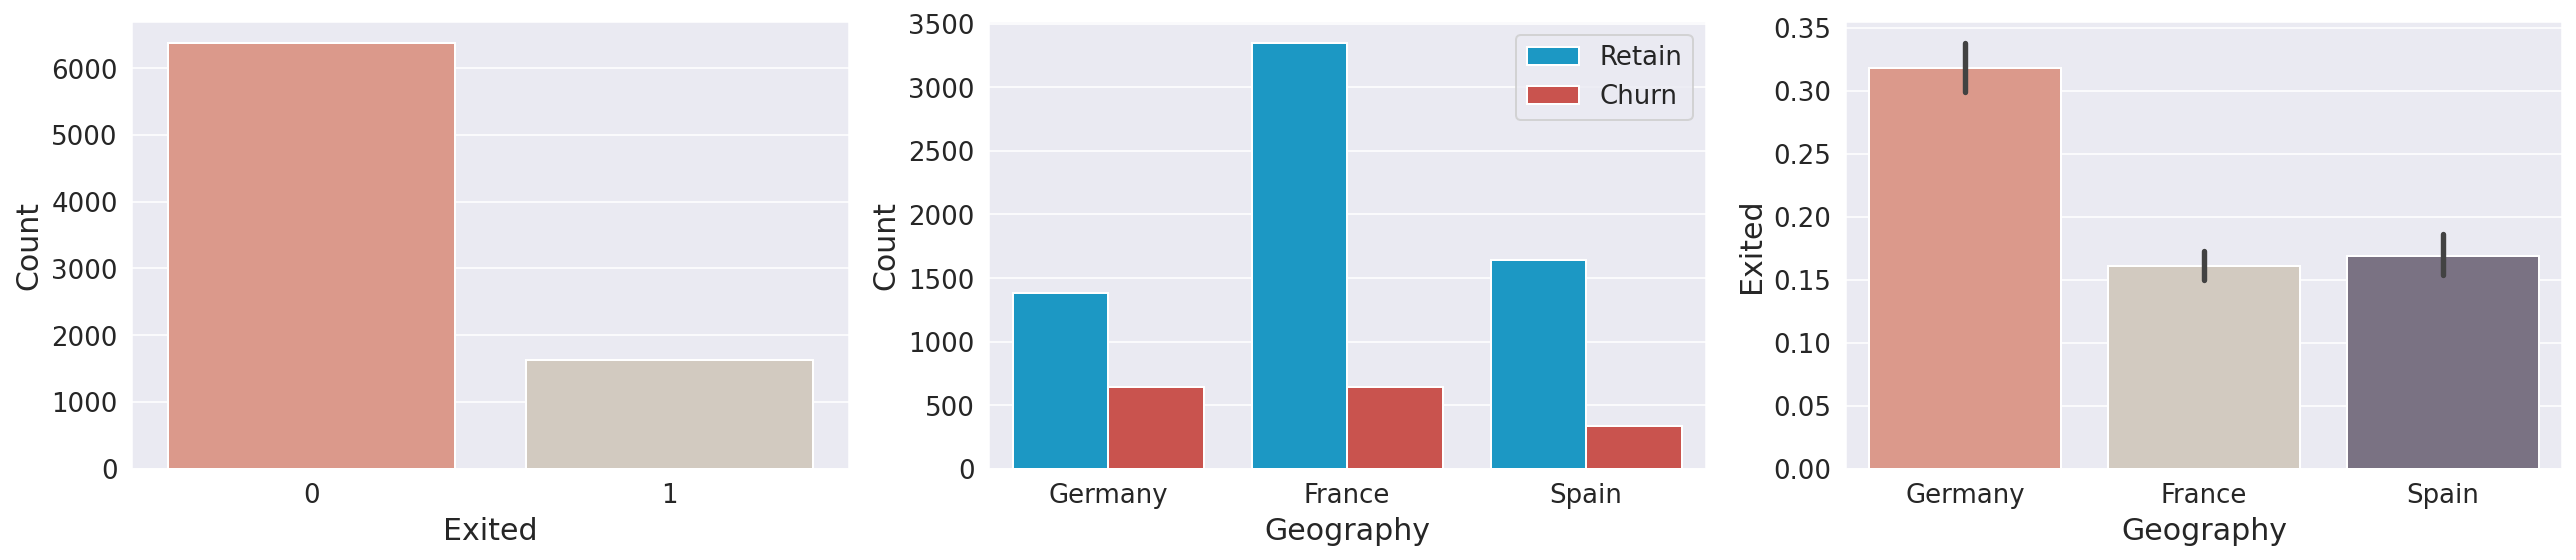

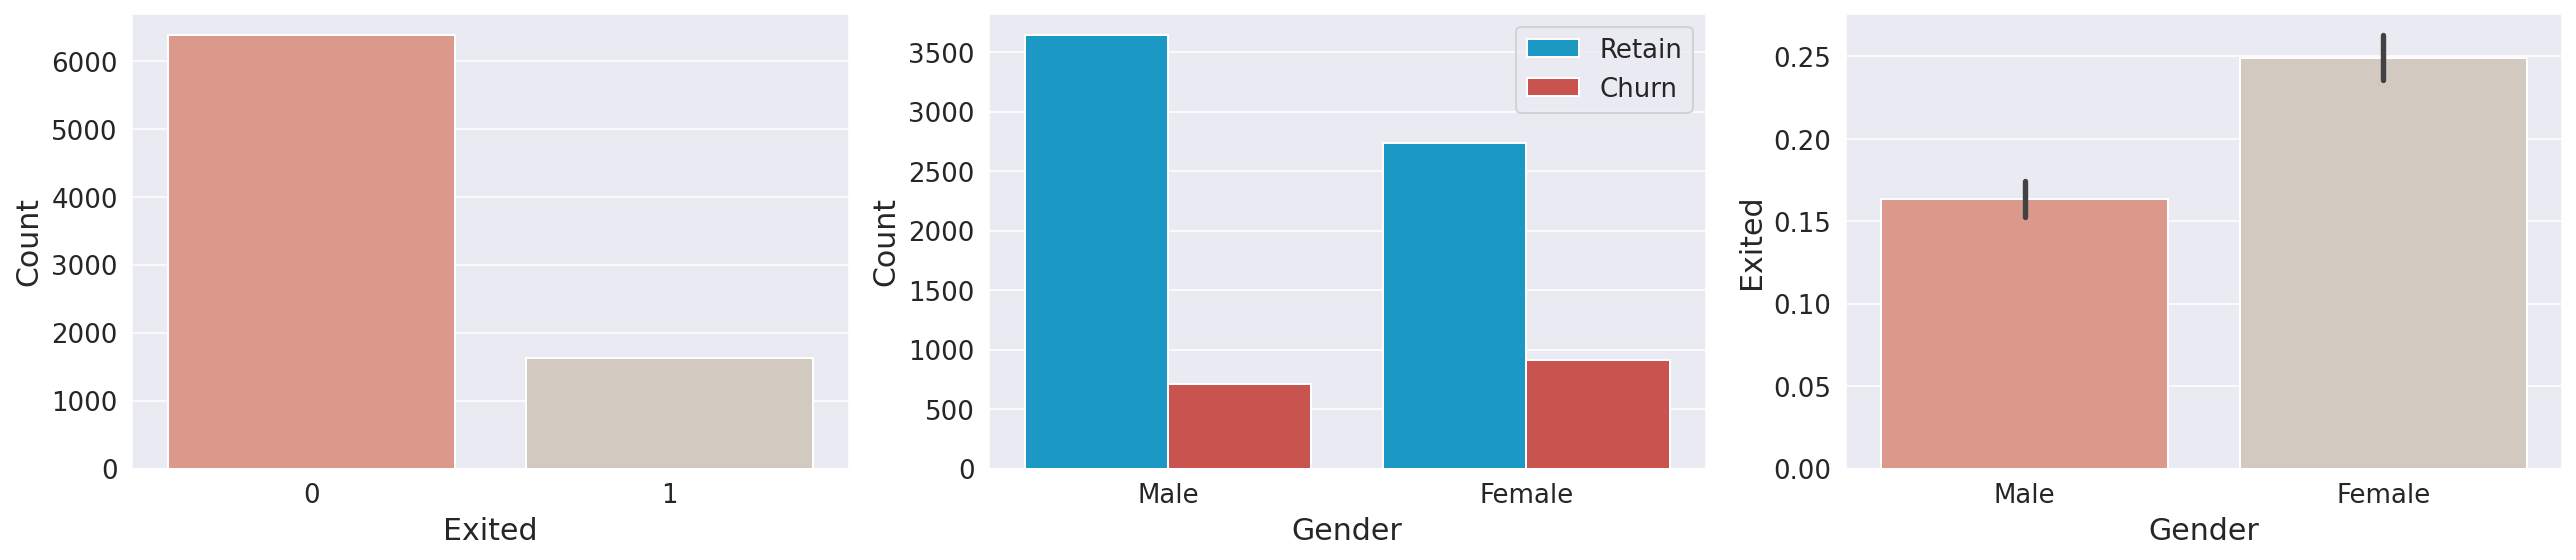

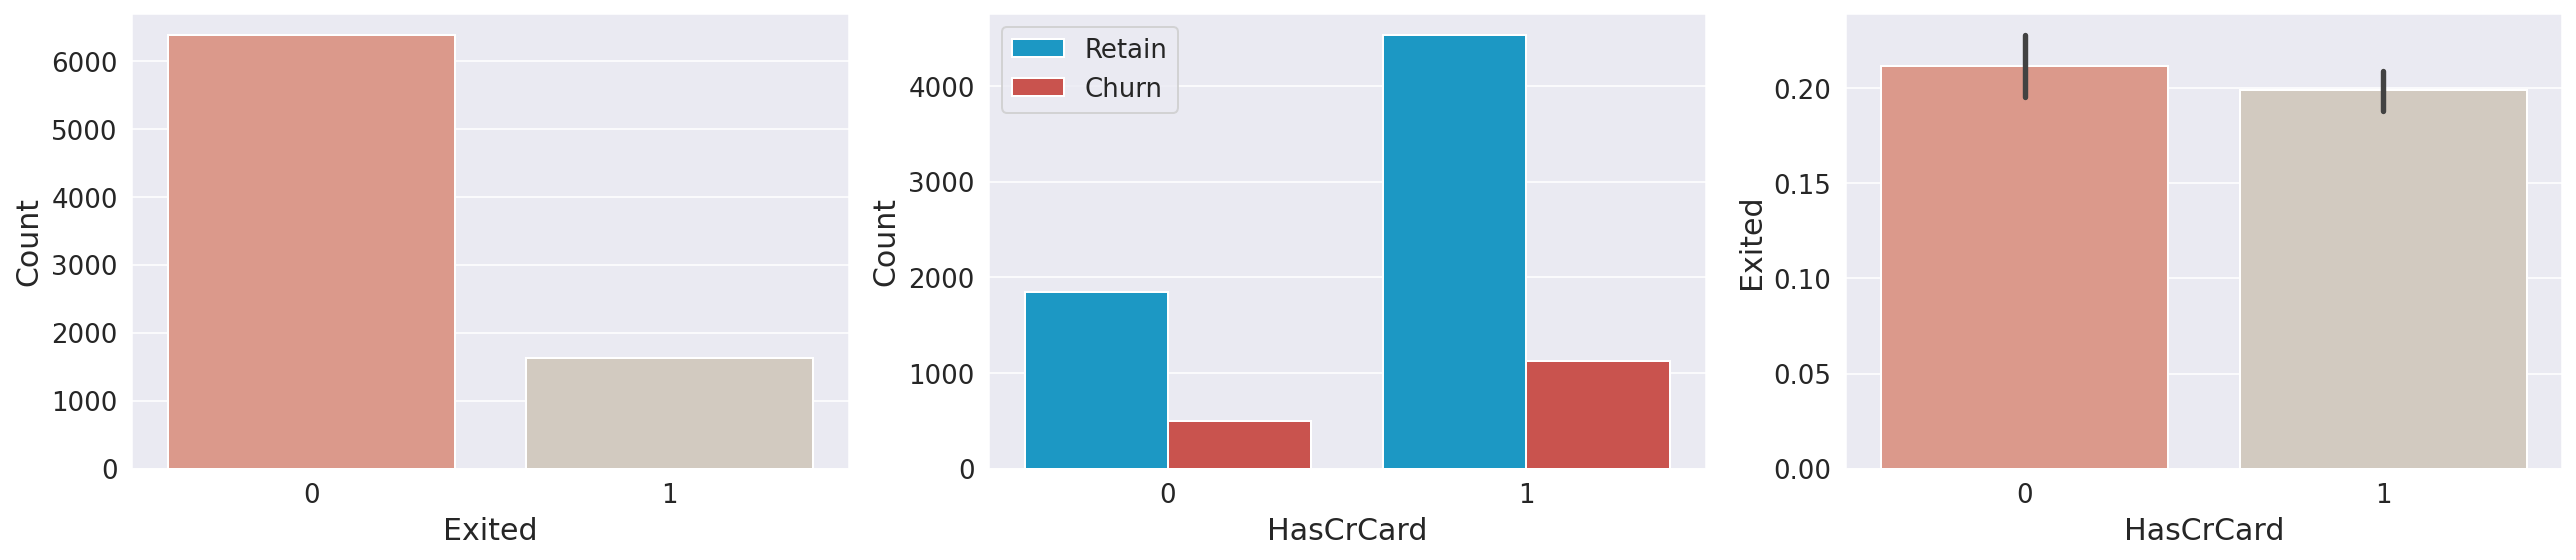

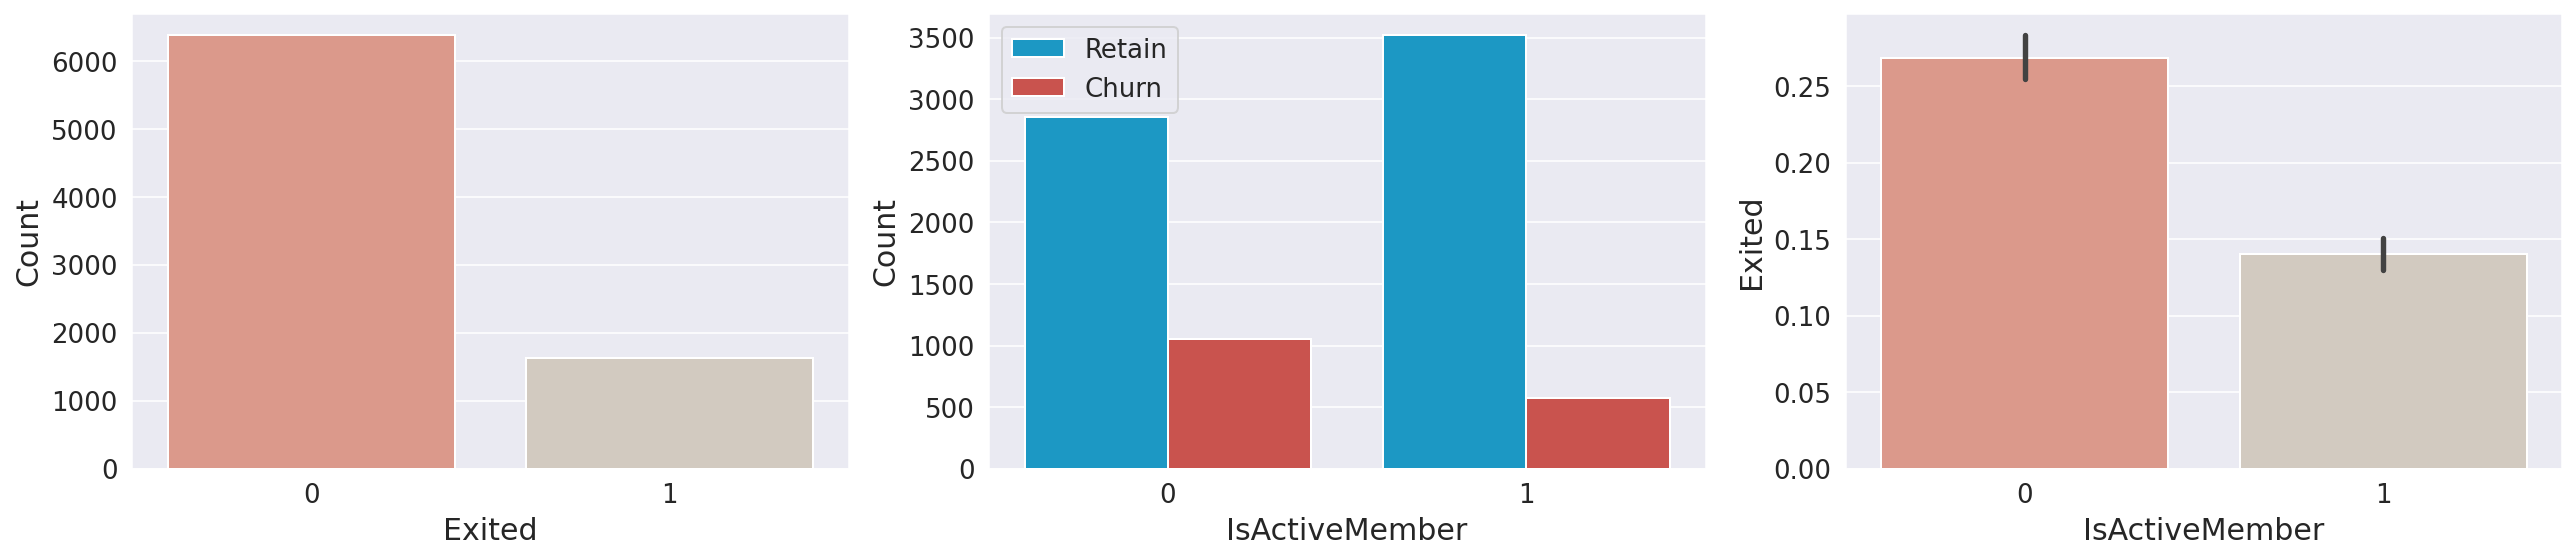

In [19]:
explor_categorical_plots(train_df,
                         feat_cols=['Geography','Gender','HasCrCard','IsActiveMember'],
                         target_col='Exited',
                         target_col_mapname=['Retain','Churn']
                         )

In [24]:
numeric_cols = list(train_df.select_dtypes(include=[np.number]).columns)

for col in ['HasCrCard','IsActiveMember','Exited']:
  numeric_cols.remove(col)

print(numeric_cols)


['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


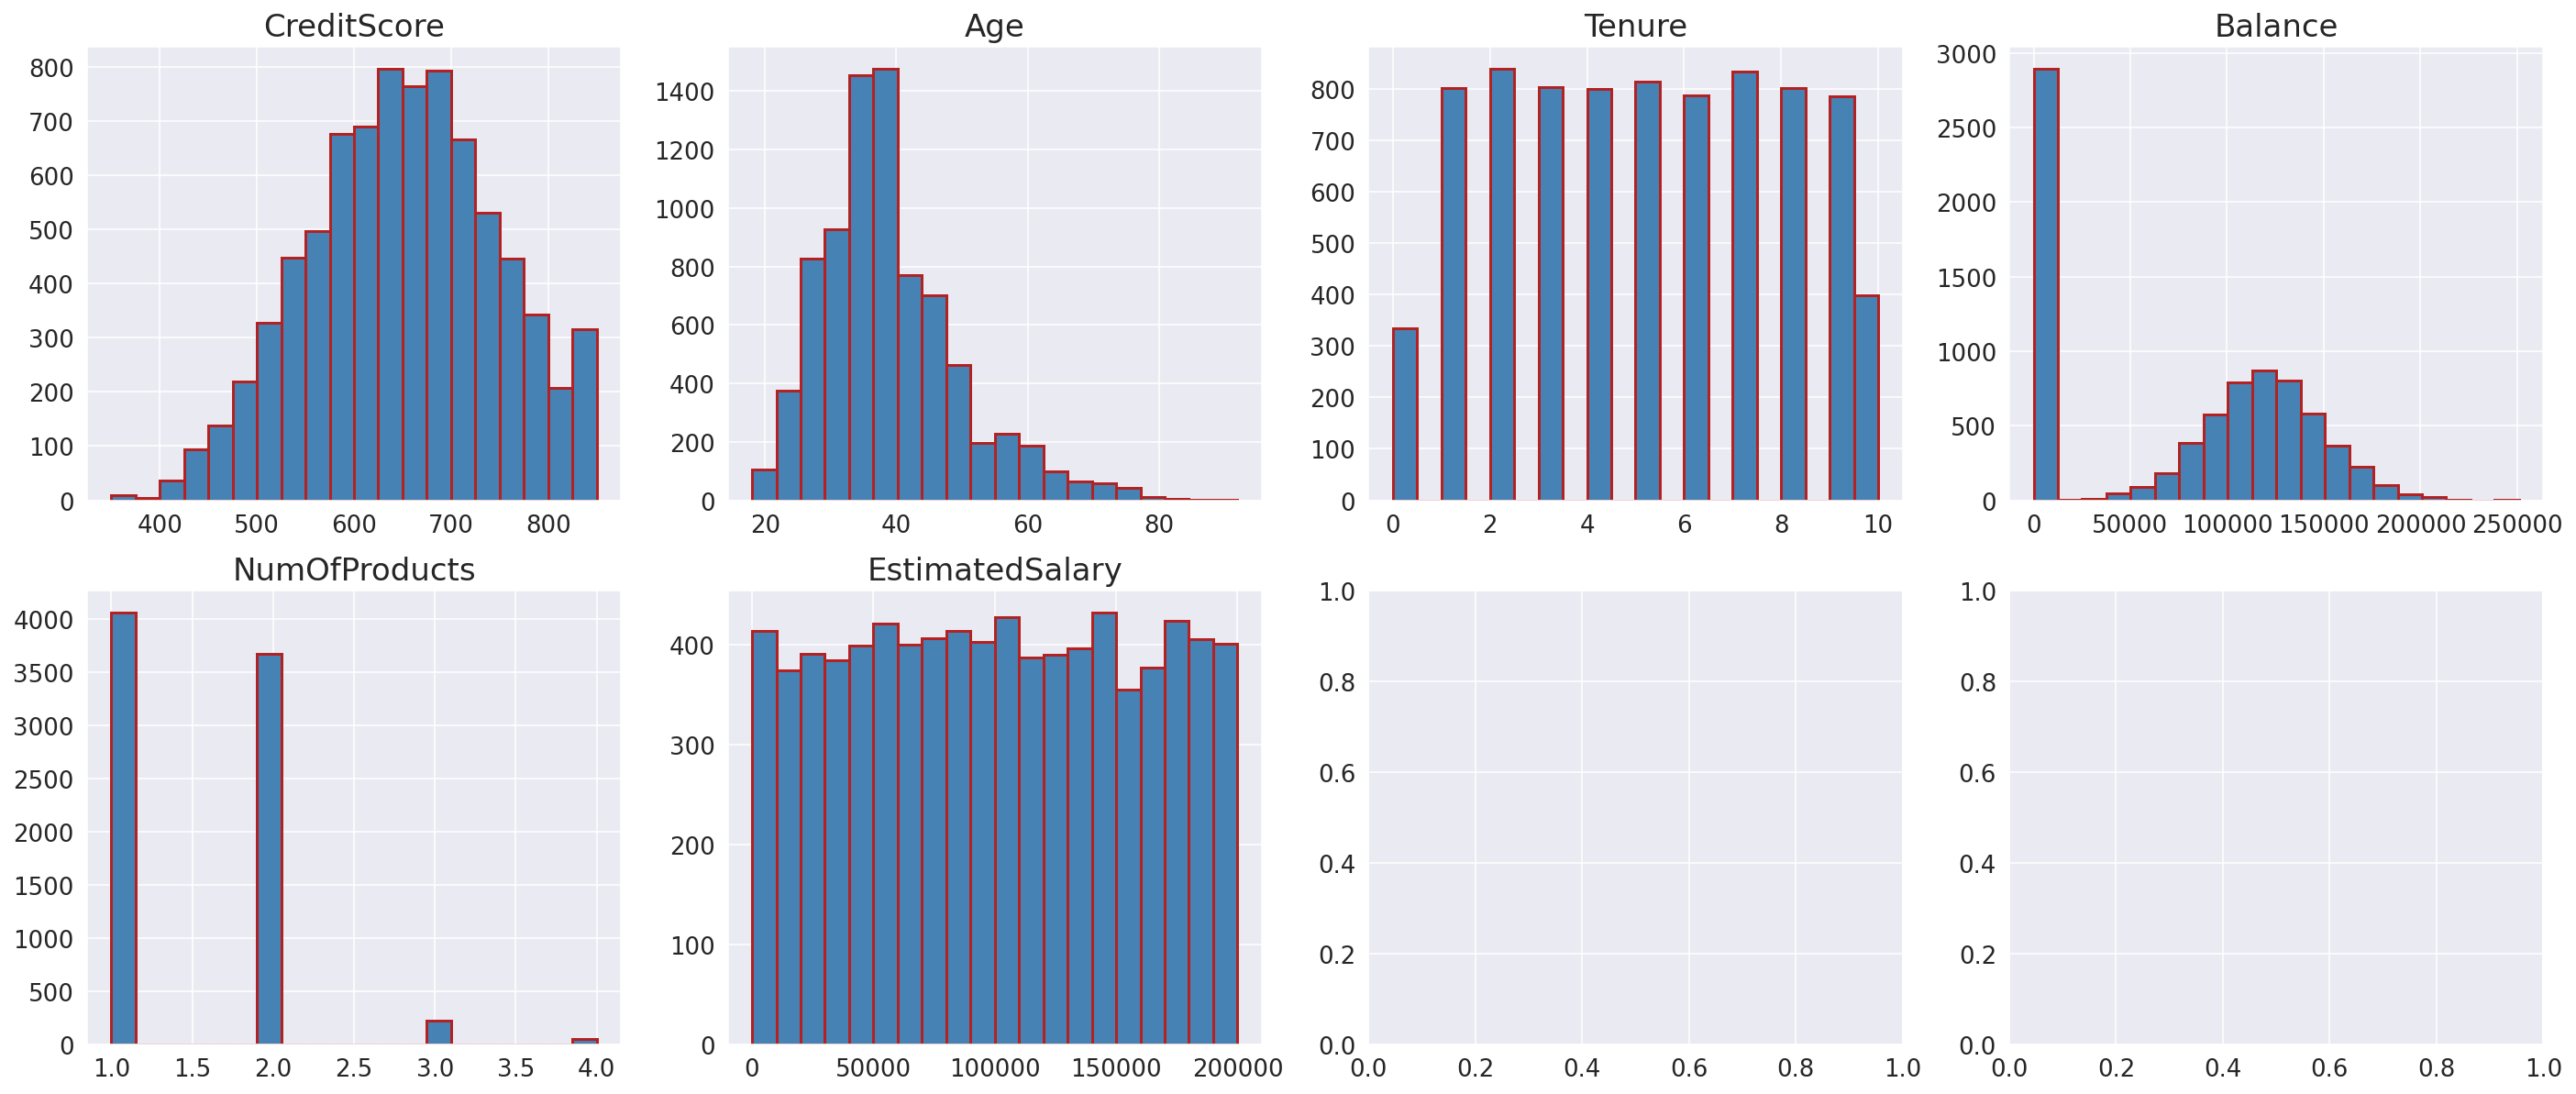

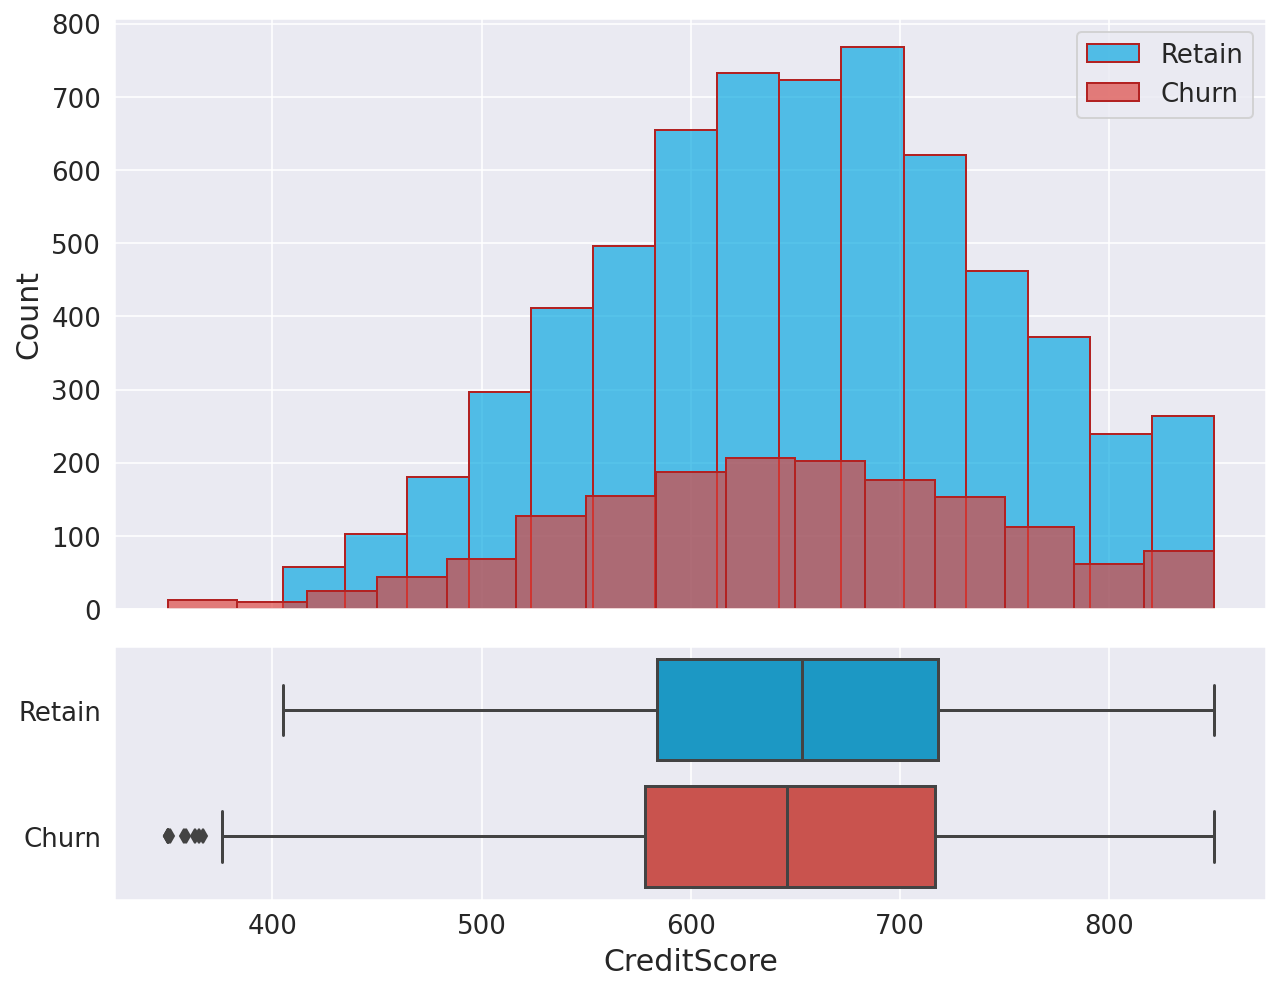

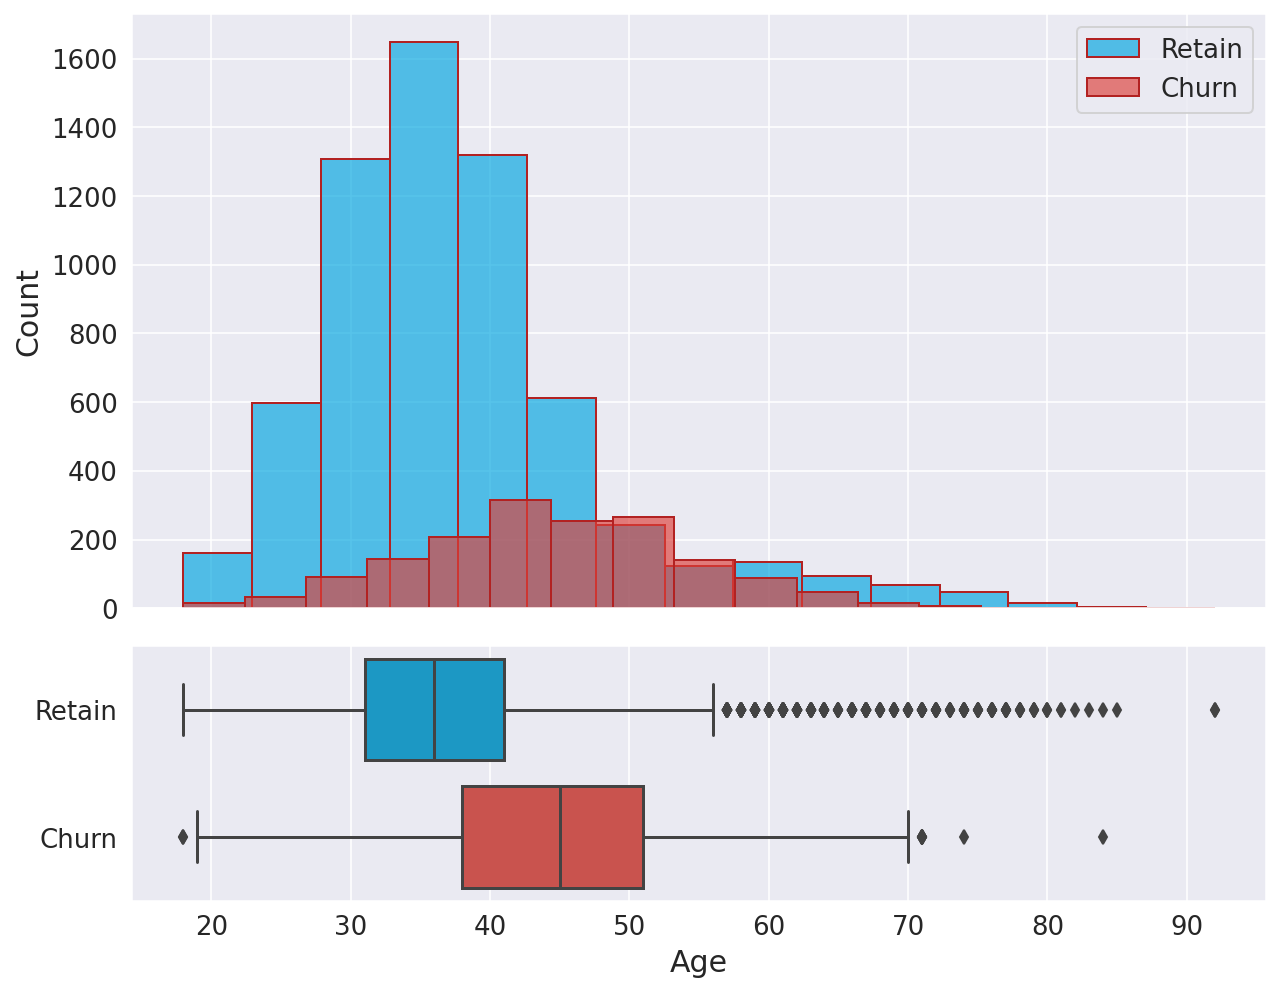

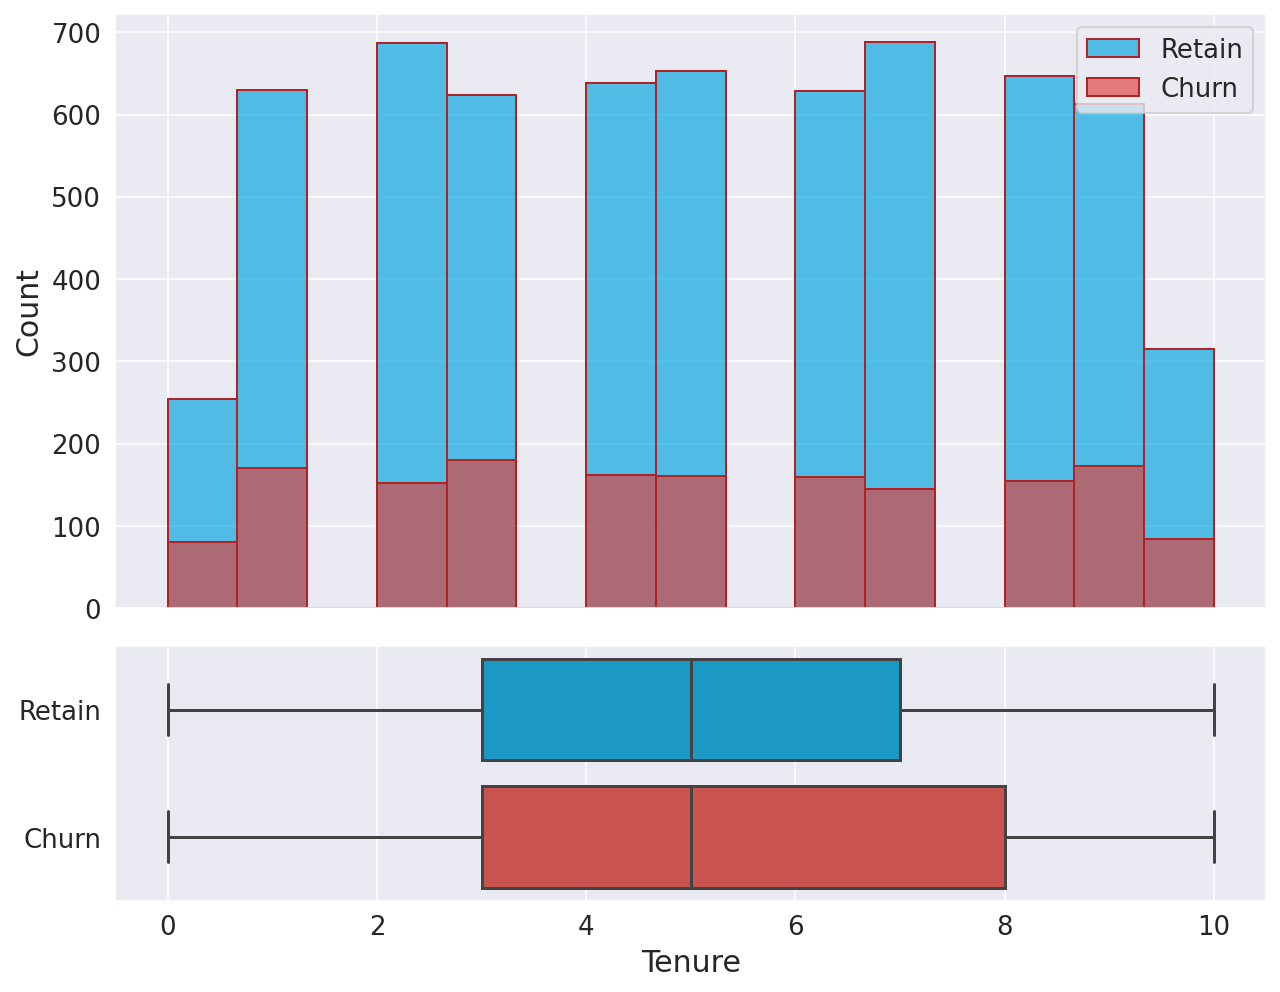

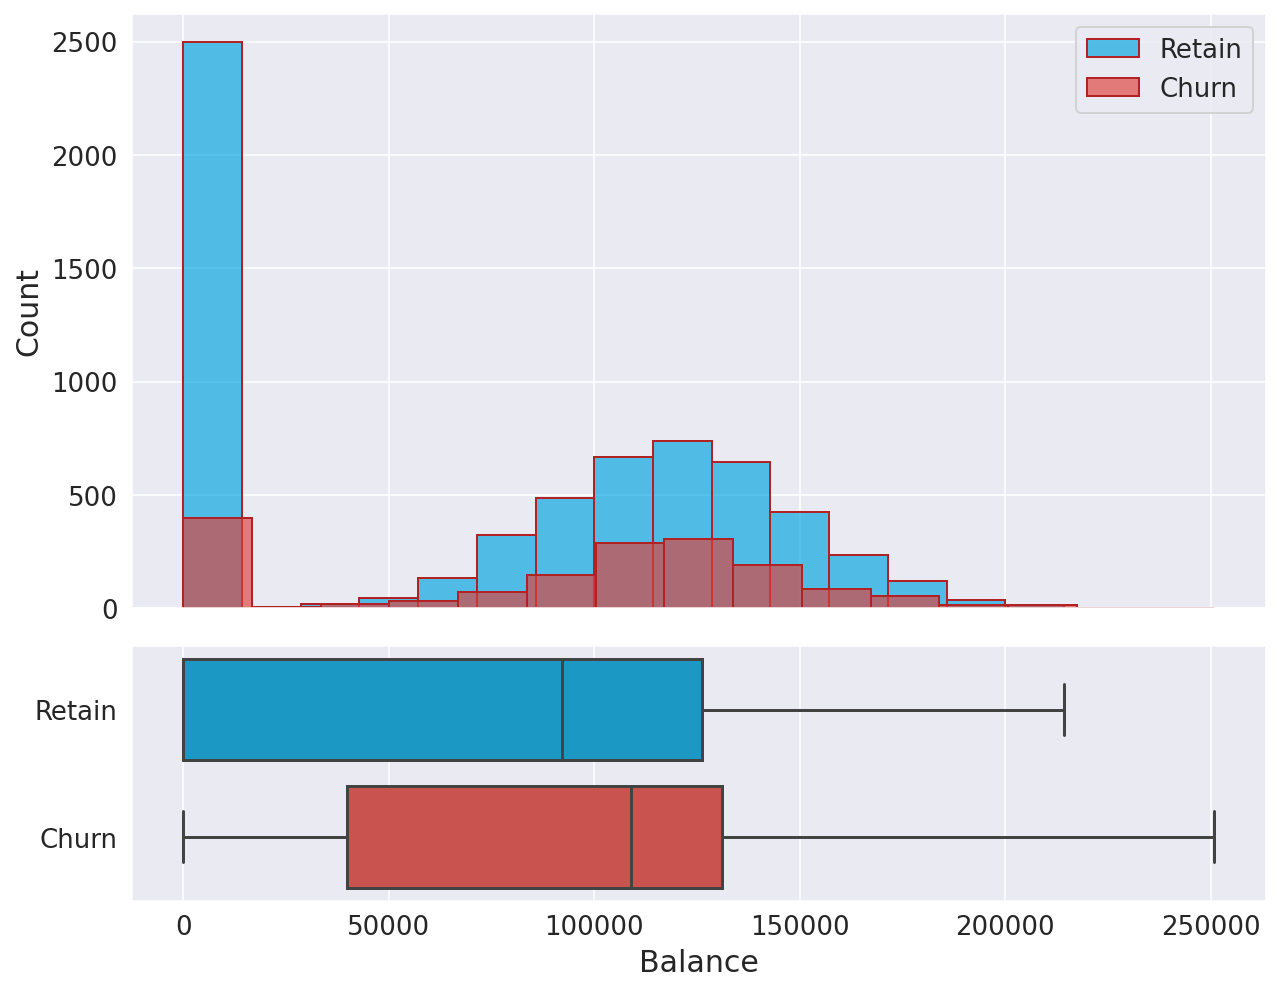

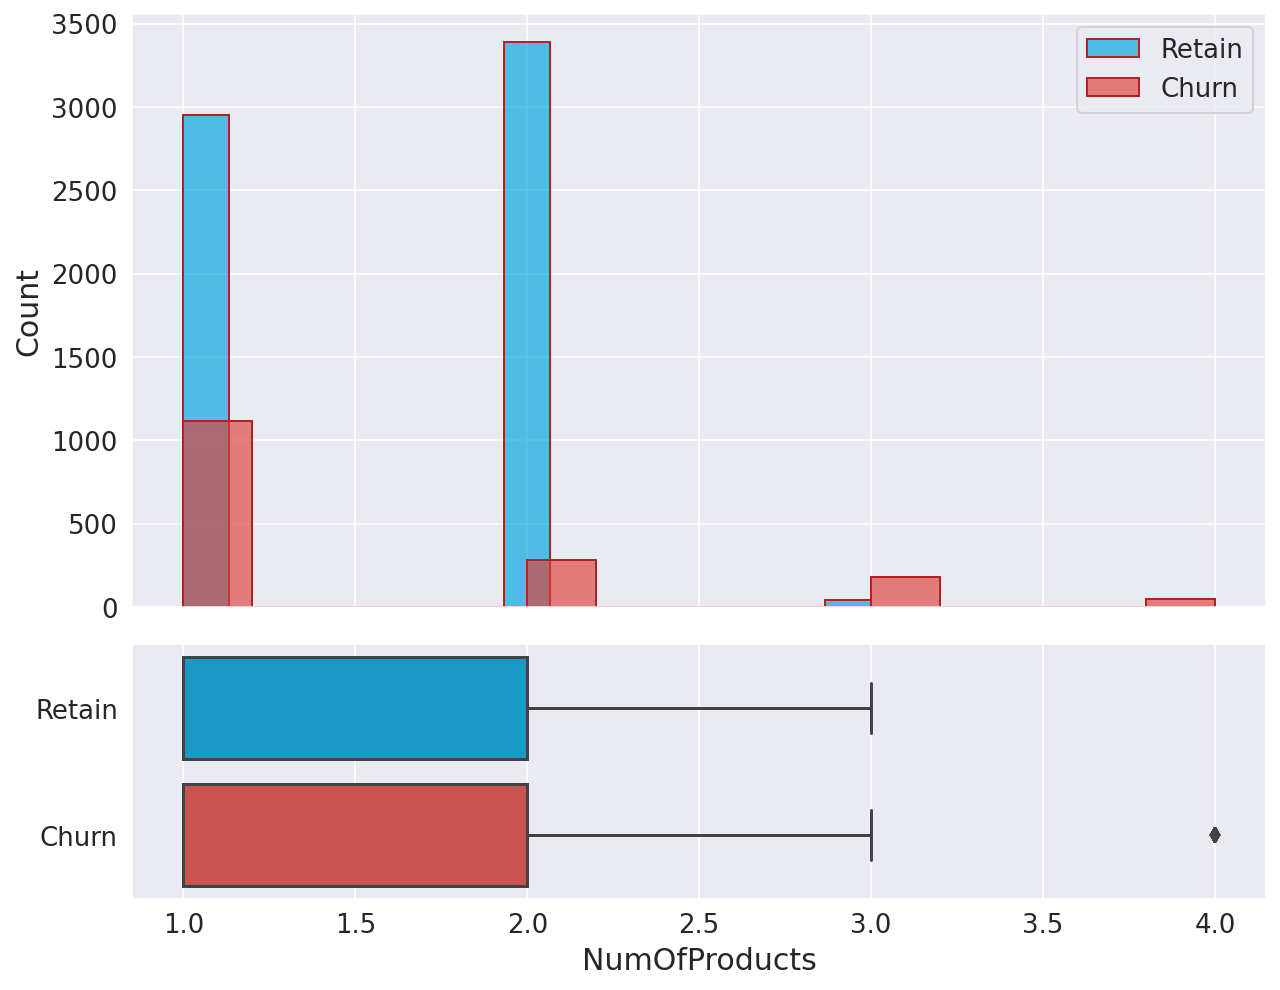

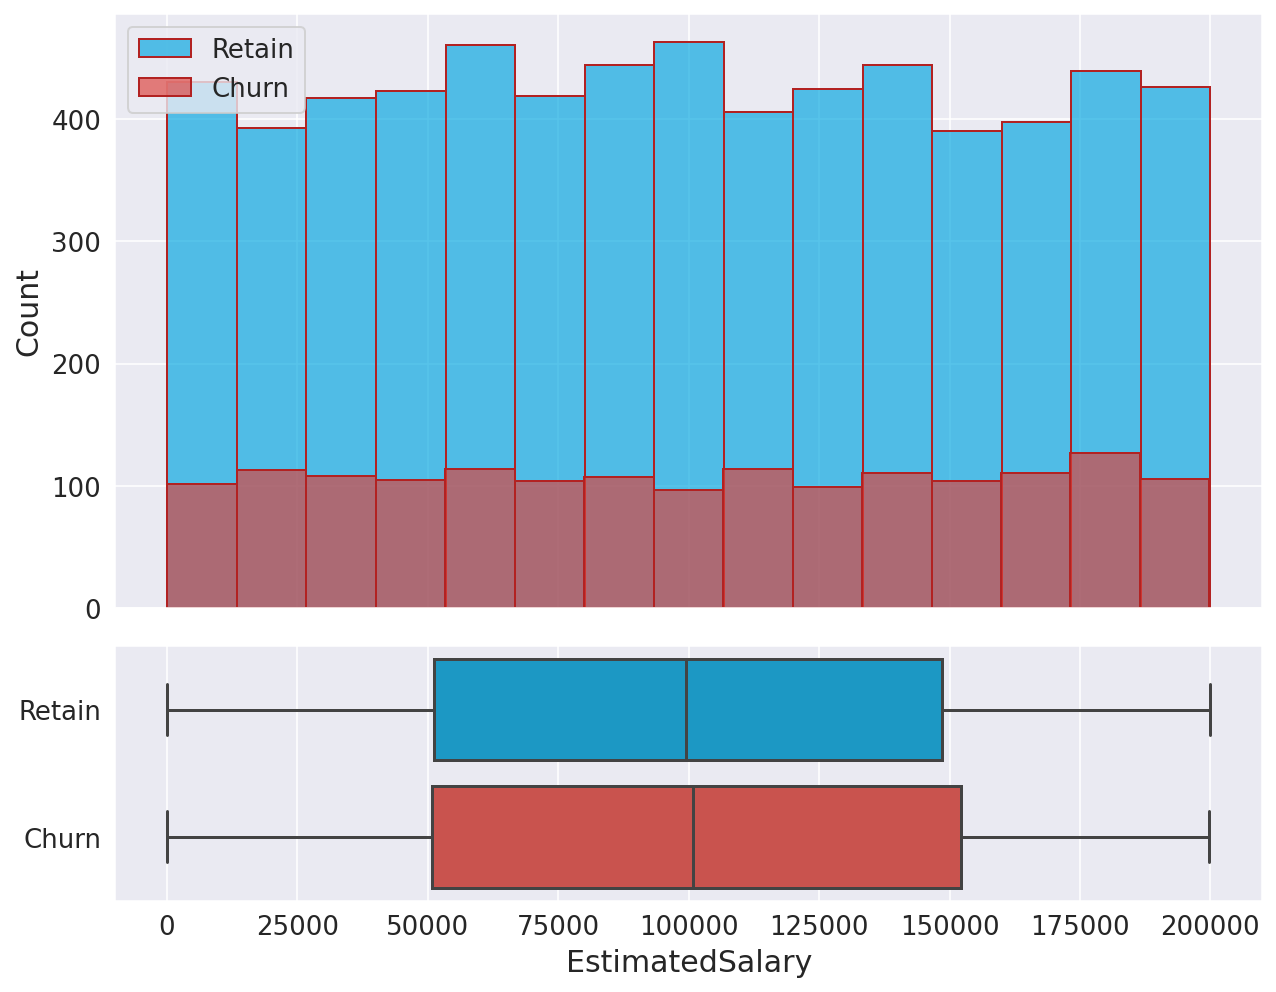

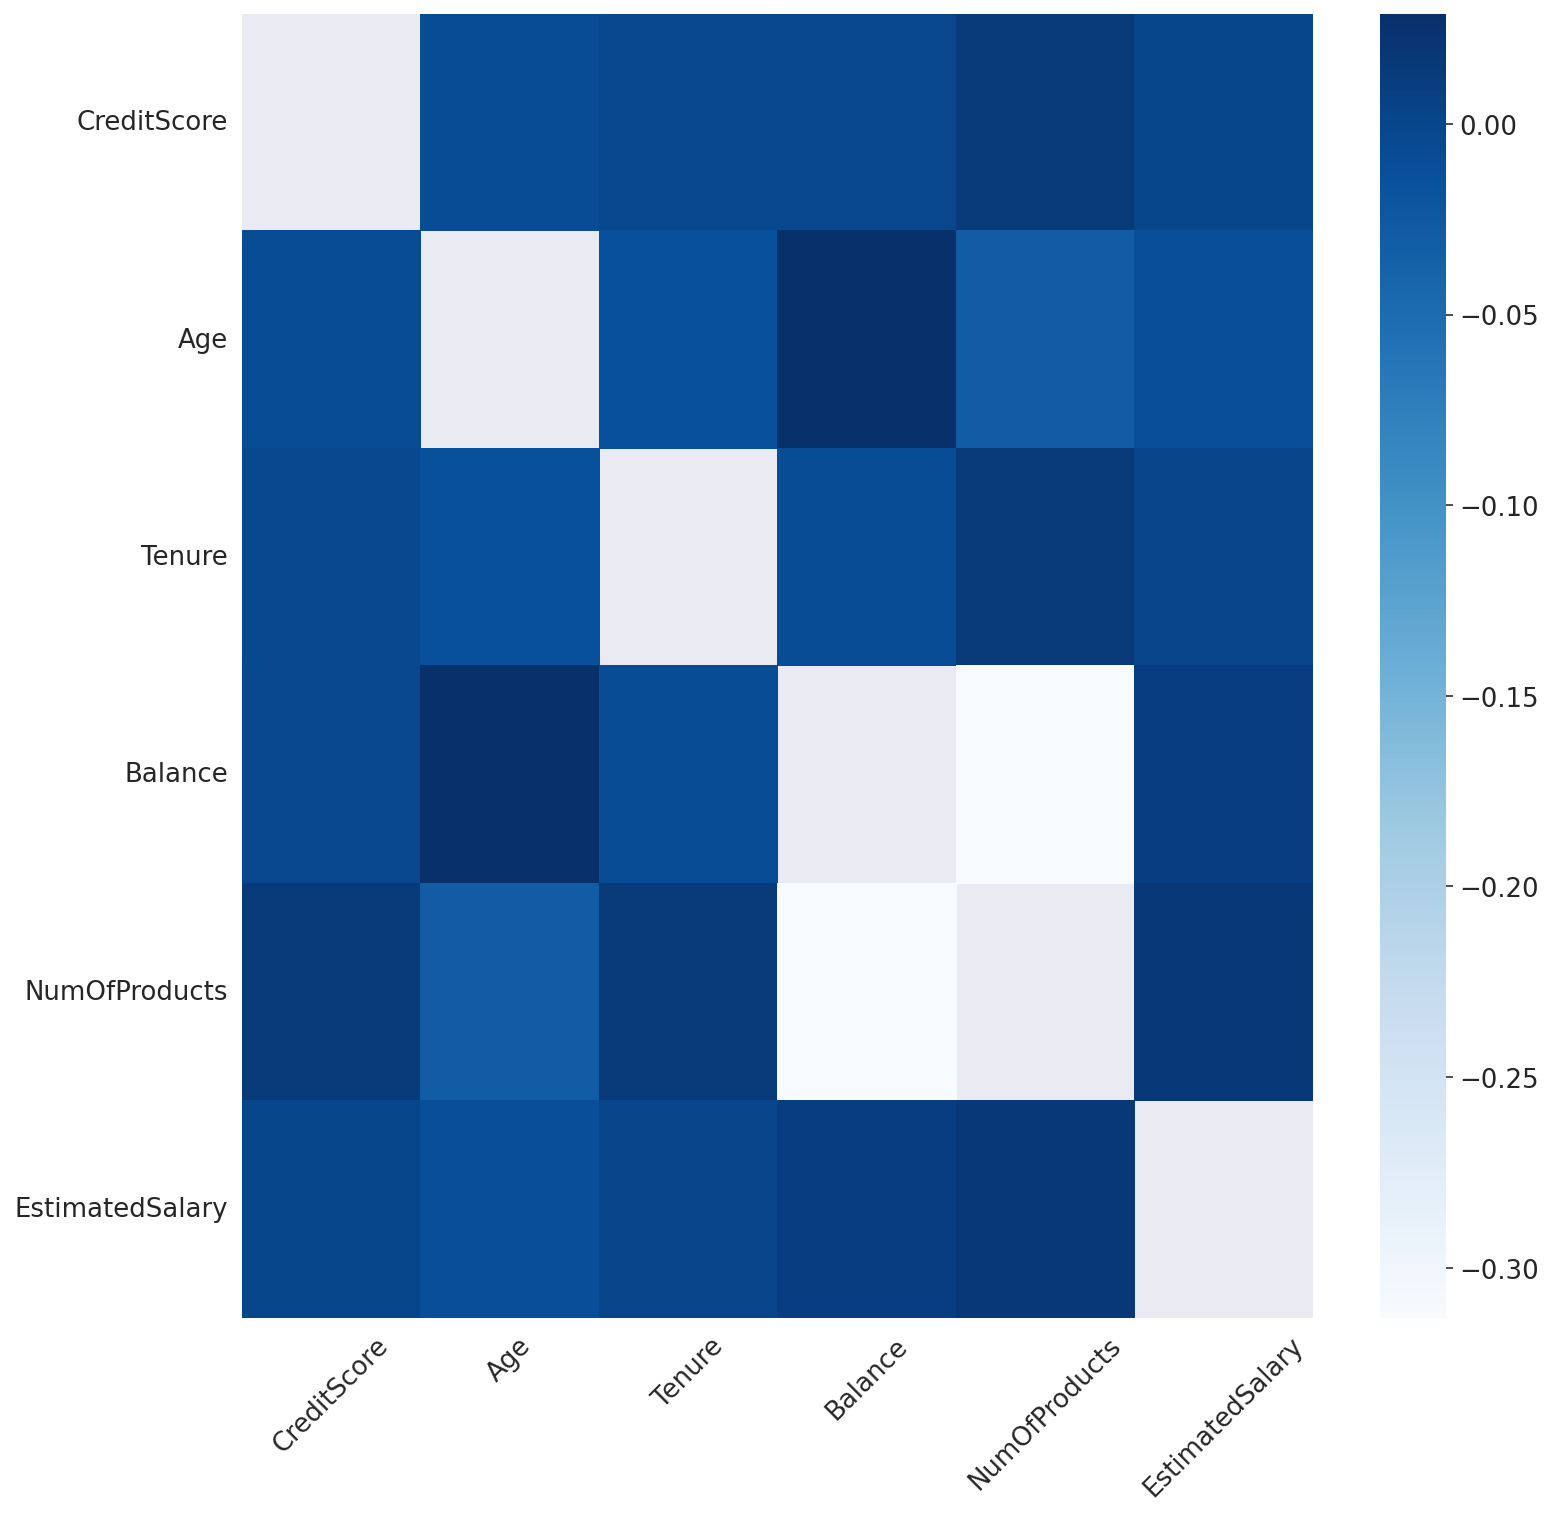

In [25]:
explor_continuous_plots(train_df,
                        numeric_cols,
                        target_col='Exited',
                        target_col_mapname=['Retain','Churn'],
                        plot_cols=4)

In [ ]:
#### Data preprocess

In [26]:
preprocess_dict = {}
"""train_df,fill_na_dict =fill_na(train_df,
                                 category_cols        =['State','Area_Code'],
                                 cont_cols            =['No_Vmail_Messages','Total_Day_minutes'],
                                 fill_category_value  ='unknown',
                              )
print(fill_na_dict)
preprocess_dict['fill_na_dict'] = fill_na_dict """

"train_df,fill_na_dict =fill_na(train_df,\n                                 category_cols        =['State','Area_Code'],\n                                 cont_cols            =['No_Vmail_Messages','Total_Day_minutes'],\n                                 fill_category_value  ='unknown',\n                              )\nprint(fill_na_dict)\npreprocess_dict['fill_na_dict'] = fill_na_dict "

In [27]:
"""train_df,target_encode_dict = target_encoder(train_df,['State'],target_col='Churn',post_fix='_TE')
preprocess_dict['target_encode_dict']= target_encode_dict """

"train_df,target_encode_dict = target_encoder(train_df,['State'],target_col='Churn',post_fix='_TE')\npreprocess_dict['target_encode_dict']= target_encode_dict "

In [28]:
# train_df['Area_Code']=train_df['Area_Code'].astype(str)
train_df,one_hot_enc_dict = one_hot_encoder(train_df,feat_cols=['Geography'])
preprocess_dict['one_hot_enc_dict']= one_hot_enc_dict

In [29]:
train_df,label_enc_dict = label_encoder(train_df,feat_cols=['Gender'],postfix='_LE')
preprocess_dict['label_enc_dict']= label_enc_dict

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_LE
2694,628,Germany,Male,29,3,113146.98,2,0,1,124749.08,0,0.0,1.0,0.0,1
5140,626,France,Female,29,4,105767.28,2,0,0,41104.82,0,1.0,0.0,0.0,0
2568,612,Germany,Female,47,6,130024.87,1,1,1,45750.21,1,0.0,1.0,0.0,0
3671,646,Germany,Female,52,6,111739.40,2,0,1,68367.18,0,0.0,1.0,0.0,0
7427,714,Spain,Male,33,8,122017.19,1,0,0,162515.17,0,0.0,0.0,1.0,1


In [31]:
train_df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_LE'],
      dtype='object')

In [32]:
feats= ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_LE'
       ]

In [ ]:
#### Train model 
#### This step is to get optiaml parameters and feature importance to select the approraite features in the final model

In [33]:
def parameter_search(X,
                     y,
                     estimator,
                     param_grid,
                     ):
  best_score = np.inf
  for g in ParameterGrid(param_grid):
    estimator.set_params(**g)
    estimator.fit(X,y)
    # save if best
    pred_train = np.argmax(estimator.oob_decision_function_,axis=1)
    oob_score = log_loss(y,pred_train)
    #print(oob_score,g)
    if oob_score < best_score:
        best_score = oob_score
        best_grid = g
  estimator.set_params(**best_grid)
  estimator.fit(X,y)
  print(f"OOB best: {best_score:.4f} and para is {best_grid}") 
  return estimator

In [34]:
rf = RandomForestClassifier(random_state=42,oob_score=True,class_weight='balanced',n_jobs=-1,bootstrap=True)
param_grid = {
    'n_estimators': [100,300],
    'criterion': ['entropy', 'gini'],
    'max_depth': [4,8],
    'max_features': [0.5, 0.8],
    'min_samples_leaf': [5,11],
    'min_samples_split': [5,11,19],
}
best_rf_clf = parameter_search(train_df[feats].values, 
                               train_df['Exited'].values,estimator=rf,param_grid=param_grid)             

OOB best: 6.2646 and para is {'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


accuracy 0.848, precision 0.5952157598499062, recall is 0.782367447595561
roc auc is 0.8235292866701542


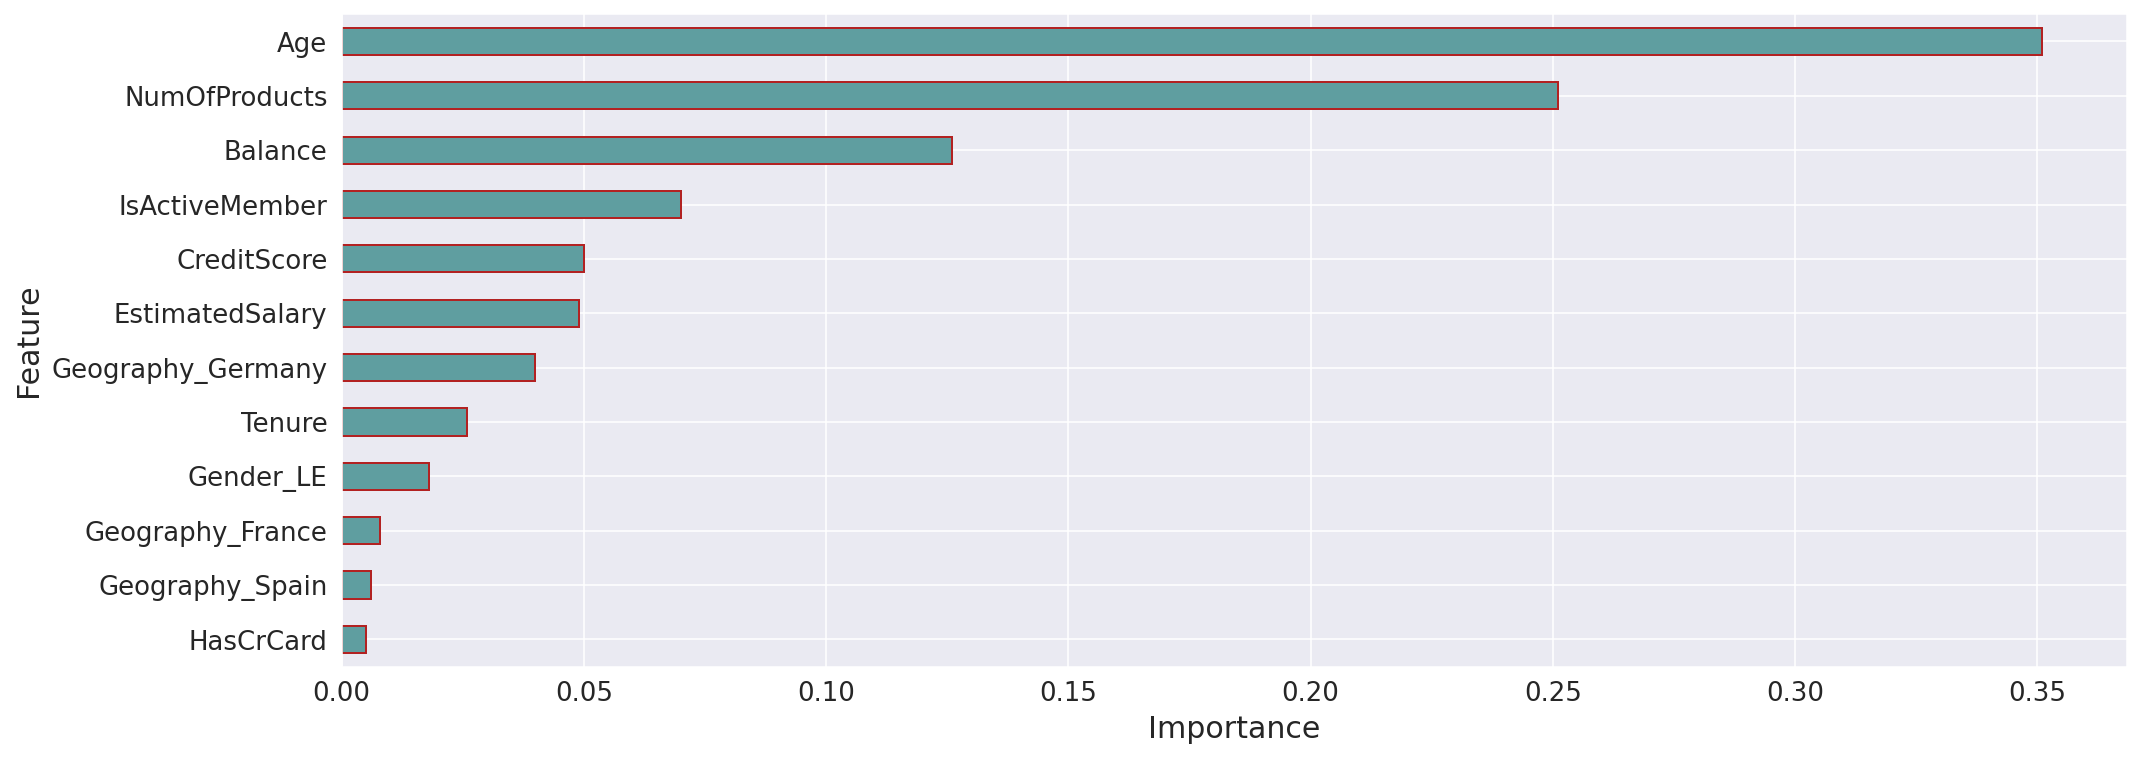

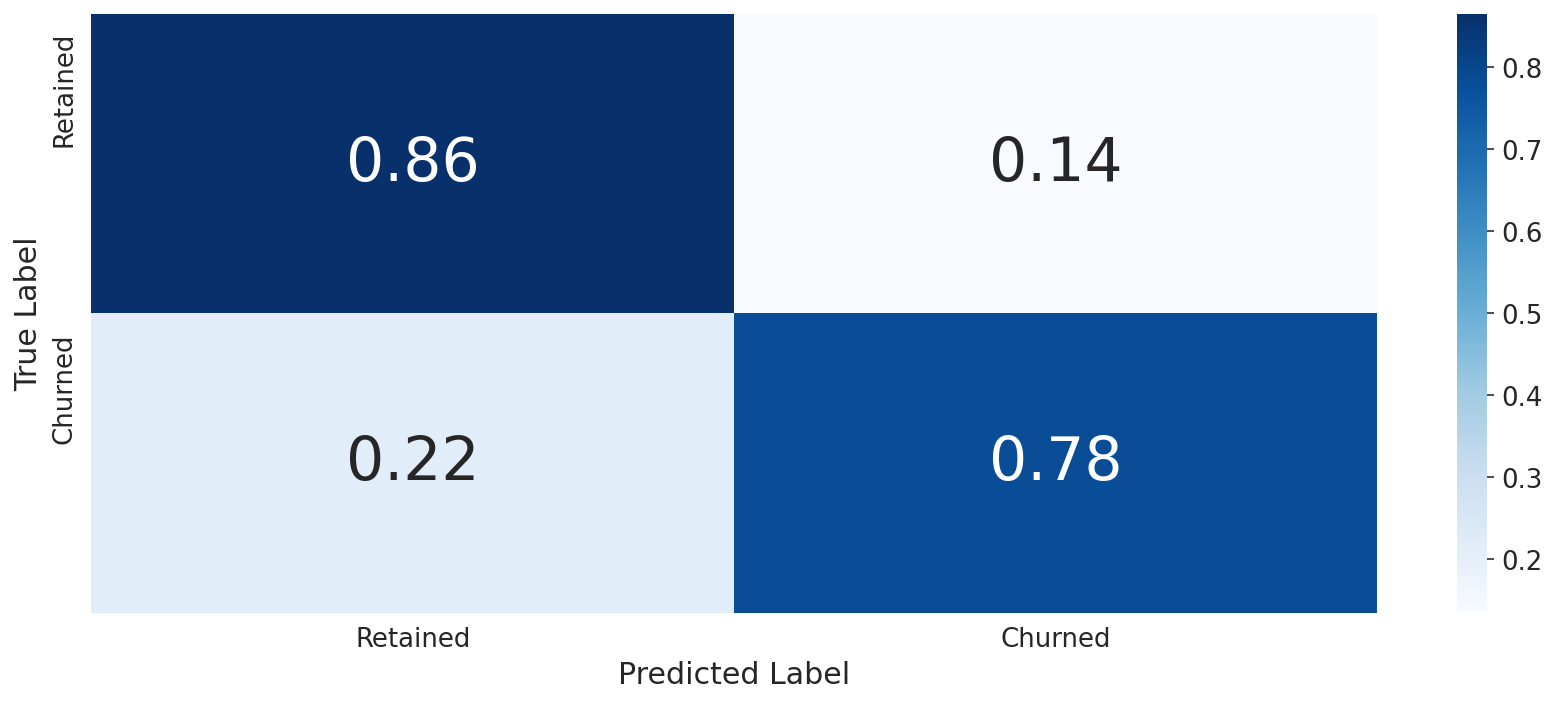

In [35]:
importances = plot_feature_imp(best_rf_clf,feats)
clf_performance(train_df[feats].values, train_df['Exited'].values,best_rf_clf, 'Random Forest', 'RF')

In [ ]:
#### Evaluate on the test set 

In [36]:
test_df = preprocess_test(test_df,preprocess_dict)

one hot encode for Geography
label encode for Gender


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


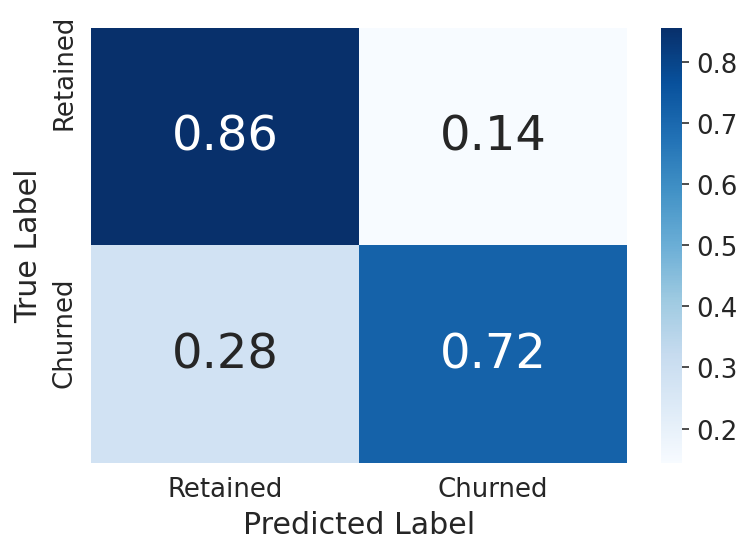

In [37]:
test_func(test_df[feats],test_df['Exited'],best_rf_clf)